In [1]:
32*32

1024

In [2]:
import numpy as np

In [5]:
a = np.array([[1,2,3],[4,5,6]])
b = np.array([[-1,-2,-3],[-4,-5,-6]])

In [6]:
a*b

array([[ -1,  -4,  -9],
       [-16, -25, -36]])

In [8]:
a.*b

SyntaxError: invalid syntax (<ipython-input-8-adb16d99f69d>, line 1)

In [9]:
a = []

In [10]:
a.append(3)

In [11]:
a

[3]

In [12]:
a.append([12,3])

In [13]:
a

[3, [12, 3]]

In [14]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import gzip
import os

import numpy
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin

from tensorflow.python.framework import dtypes
from tensorflow.python.framework import random_seed
from tensorflow.python.platform import gfile
from tensorflow.python.util.deprecation import deprecated

_Datasets = collections.namedtuple('_Datasets', ['train', 'validation', 'test'])

In [2]:
import collections
_Datasets = collections.namedtuple('_Datasets', ['train', 'validation', 'test'])

## 예제 3-5 MNIST 데이터에 대한 희박 오토인코더 (수정)

In [1]:
## 필요한 라이브러리를 불러들임 
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# MNIST 데이터 읽어들임
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


In [4]:
# 학습관련 매개변수 설정
learning_rate = 0.001
wgt_decay = 0.0001
sparse_penalty = 0.001
batch_size = 1000
display_step = 1
examples_to_show = 10

In [5]:
n_input = 28*28 # MNIST 데이터 입력 
n_hidden = 32*32 # 은닉노드 개수

In [6]:
# 입력, 가중치 및 편향을 정의함
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h': tf.Variable(tf.random_normal([n_input,n_hidden])), # 784 * 1024
    'decoder_h': tf.Variable(tf.random_normal([n_hidden,n_input])), # 1024 * 784
}    
biases = {
    'encoder_b': tf.Variable(tf.random_normal([n_hidden])), # 1024 * 1
    'decoder_b': tf.Variable(tf.random_normal([n_input])),  # 784 * 1
}

In [7]:
# 인코더를 구축함
def encoder(x):
    # sigmoid(X(M, 784) .* W1(784, 1024) + b1(1024, 1)) = a1(M, 1024)
    e_layer = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h']),
                                   biases['encoder_b']))
    return e_layer

In [8]:
# 수정됨
# 디코더를 구축함
def decoder(x):
    # sigmoid(a1(M, 1024) .* W2(1024 * 784) + b2(784, 1)) = a2(M, 784)
    # (기존) d_layer = tf.nn.sigmoid(tf.add(tf.matmul(x, tf.transpose(weights['encoder_h'])), biases['decoder_b']))
    d_layer = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h']), biases['decoder_b']))
    return d_layer

In [9]:
# Kullback Leibler 정보량 계산
def kl_div(rho, rho_hat):
    # Kullback Leibler divergence
    return rho * tf.log(rho / rho_hat) + (1 - rho) * tf.log((1 - rho) / (1 - rho_hat))

In [10]:
# 수정됨
# 오토인코더 모형 구축
op_encoder = encoder(X)
print(op_encoder.shape)
op_decoder = decoder(op_encoder)
print(op_decoder.shape)
# (기존) rho_hat = tf.reduce_mean(op_encoder,1) # 인코더층의 출력값을 column 기준으로 평균을 낸다. 즉, 모든 input X에 대한 인코더층의 출력값을 노드별로 평균낸다.
rho_hat = tf.reduce_mean(op_encoder,0) 
print(rho_hat.shape)

(?, 1024)
(?, 784)
(1024,)


In [11]:
# 예측값
y_true = X
y_pred = op_decoder

In [12]:
# 손실함수 및 최적화 정의 
loss_mse = tf.reduce_mean(tf.square(y_true - y_pred))
loss_reg = wgt_decay*tf.nn.l2_loss(weights['encoder_h']) # wgt_decay(0.0001) * 인코더층의 가중치행렬에 대한 L2 regularization
loss_sparse = sparse_penalty*tf.reduce_sum(kl_div(0.2,rho_hat)) # sparse_penalty(0.001) * KL정보량(Kullback_Leibler divergence)
#loss = loss_mse + loss_reg + loss_sparse # 최종 손실함수
loss = loss_mse + loss_reg # 최종 손실함수

In [13]:
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch: 0001 loss = 40.608291626
Epoch: 0002 loss = 40.561756134
Epoch: 0003 loss = 39.812362671
Epoch: 0004 loss = 36.822235107
Epoch: 0005 loss = 33.565002441
Epoch: 0006 loss = 30.616767883
Epoch: 0007 loss = 27.885225296
Epoch: 0008 loss = 25.361396790
Epoch: 0009 loss = 23.025476456
Epoch: 0010 loss = 20.868330002
Epoch: 0011 loss = 18.879806519
Epoch: 0012 loss = 17.051586151
Epoch: 0013 loss = 15.369082451
Epoch: 0014 loss = 13.829712868
Epoch: 0015 loss = 12.419402122
Epoch: 0016 loss = 11.138426781
Epoch: 0017 loss = 9.968153954
Epoch: 0018 loss = 8.904924393
Epoch: 0019 loss = 7.939997196
Epoch: 0020 loss = 7.065692902
Epoch: 0021 loss = 6.278196812
Epoch: 0022 loss = 5.566510677
Epoch: 0023 loss = 4.927493572
Epoch: 0024 loss = 4.354053497
Epoch: 0025 loss = 3.838811398
Epoch: 0026 loss = 3.379621506
Epoch: 0027 loss = 2.970266342
Epoch: 0028 loss = 2.605150938
Epoch: 0029 loss = 2.281527996
Epoch: 0030 loss = 1.993701935
Epoch: 0031 loss = 1.740757346
Epoch: 0032 loss = 1.51

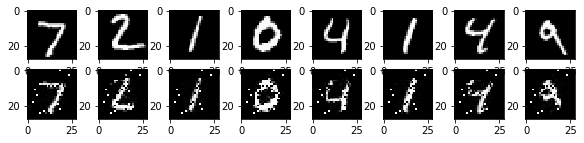

In [14]:
# 텐서플로 그래프 실행
start_time = time.time()
sess = tf.Session()
# 모형의 변수들을 초기화하기
init = tf.global_variables_initializer()
sess.run(init)
num_batch = int(mnist.train.num_examples/batch_size)
# 학습 과정
num_epoch = 100
for epoch in range(num_epoch):
    # 모든 미니배치에 대해 반복함
    for i in range(num_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, los = sess.run([optimizer, loss], feed_dict={X: batch_xs})
    # 실행 단계 보여주기
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "loss =", "{:.9f}".format(los))

print("Optimization Finished!")

# 검정 데이터 집합에 인코더와 디코더를 적용함
n_digit = 8
reconstruct_digit = sess.run(y_pred, feed_dict={X: mnist.test.images[:n_digit]})
# 검정 데이터에 속하는 원래 이미지와 복원된 이미지를 비교함 
fig, a = plt.subplots(2, n_digit, figsize=(10, 2))
for i in range(n_digit):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)),cmap='gray')
    a[1][i].imshow(np.reshape(reconstruct_digit[i], (28, 28)),cmap='gray')
# 인코더 및 디코더 관련 가중치를 저장함 
w_encod = sess.run(weights['encoder_h'])
w_decod = sess.run(weights['decoder_h'])

end_time = time.time()
print('elapsed time:',end_time - start_time)

In [15]:
encoder_digit = sess.run(op_encoder, feed_dict={X: mnist.test.images})

In [16]:
encoder_digit.shape

(10000, 1024)

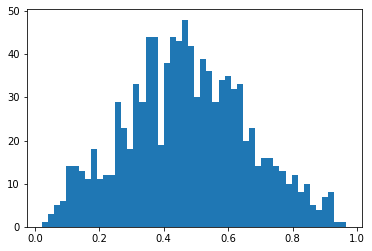

In [17]:
_ = plt.hist(np.mean(encoder_digit, 0), bins=50)

In [ ]:
_ = plt.hist(encoder_digit, )